# Anomalies in 4G cellular networks
## Explore ML solutions to detect abnormal behaviour of eNB


# Imports

In [2]:
# Data preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Feature Engeenering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Classification
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV


#others
import math


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read data

In [4]:
#train_df = pd.read_csv('/content/drive/MyDrive/APA/anomalies-in-4g-cellular-networks/ML-MATT-CompetitionT21_train.csv', sep=';')
#test_df = pd.read_csv('/content/drive/MyDrive/APA/anomalies-in-4g-cellular-networks/ML-MATT-CompetitionT21_test.csv', sep=';')

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml-seminar/anomalies-in-4g-cellular-networks/ML-MATT-CompetitionT21_train.csv', sep=';')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml-seminar/anomalies-in-4g-cellular-networks/ML-MATT-CompetitionT21_test.csv', sep=';')

In [6]:
train_df.head(3)

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,10:45,3BLTE,12.3848,1.4019,0.3927,0.0438,16.6522,0.6806,1.1293,1.0491,5,3,8,1
1,9:45,1BLTE,22.0438,2.0016,0.5620,0.2697,10.3994,1.1771,1.4480,1.1630,6,5,11,1
2,7:45,9BLTE,0.5105,0.4258,0.0152,0.0106,0.2755,0.1685,1.0379,1.0535,1,2,3,1


Proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

In [7]:
neg, pos = np.bincount(train_df.Unusual)
total = neg + pos
print('Examples:\n    Total: {}\n    Unusual: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 36904
    Unusual: 10183 (27.59% of total)



In [108]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36904 entries, 0 to 36903
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         36904 non-null  object 
 1   CellName     36904 non-null  object 
 2   PRBUsageUL   36904 non-null  float64
 3   PRBUsageDL   36904 non-null  float64
 4   meanThr_DL   36904 non-null  float64
 5   meanThr_UL   36904 non-null  float64
 6   maxThr_DL    36904 non-null  float64
 7   maxThr_UL    36904 non-null  float64
 8   meanUE_DL    36904 non-null  float64
 9   meanUE_UL    36904 non-null  float64
 10  maxUE_DL     36904 non-null  int64  
 11  maxUE_UL     36904 non-null  int64  
 12  maxUE_UL+DL  36904 non-null  int64  
 13  Unusual      36904 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 3.9+ MB


In [109]:
train_df.describe()

,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
count,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000
mean,7.897706,2.124434,0.565398,0.068173,17.926552,1.808755,1.184777,0.671641,4.320345,3.124648,7.444992,0.275932
std,8.472748,2.261744,0.733322,0.187839,15.870278,5.078689,0.213374,0.540480,1.785513,1.402753,3.051653,0.446989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.213000,0.707000,0.142000,0.021800,5.770650,0.366850,1.052000,0.010000,3.000000,2.000000,5.000000,0.000000
50%,4.547000,1.379150,0.356000,0.040000,14.304000,0.711000,1.132000,1.011000,4.000000,3.000000,7.000000,0.000000
75%,12.328000,2.826900,0.725000,0.075000,25.291750,1.252100,1.273000,1.068700,5.000000,4.000000,9.000000,1.000000
max,51.333000,77.505000,19.601000,12.461000,148.478500,49.690600,3.035400,2.668000,13.000000,12.000000,24.000000,1.000000


# Categorical values to numeric values

In [8]:
# Train
train = train_df.copy()
train = train.drop('Time', axis='columns')

# Test
test = test_df.copy()
test = test.drop('Time', axis='columns')

**--> Time feature**

In [9]:
# Transfomr 'Time' that is a categorical feature to numerical
def timeToMin(x): 
    h, m = x.split(':')
    return int(h)*60+int(m)

In [10]:
# Training
# Calcule the angle of the hour. 23:45 y closer to 00:00
train['TimeCos'] = train_df['Time'].apply(lambda t: math.cos(timeToMin(t)))
train['TimeSin'] = train_df['Time'].apply(lambda t: math.sin(timeToMin(t)))

timeCos = train['TimeCos']
train = train.drop('TimeCos', axis='columns')
train.insert(0, 'TimeCos', timeCos)

timeSin = train['TimeSin']
train = train.drop('TimeSin', axis='columns')
train.insert(1, 'TimeSin', timeSin)

In [11]:
# Test dataset for submission
# Calcule the angle of the hour. 23:45 y closer to 00:00
test['TimeCos'] = test_df['Time'].apply(lambda t: math.cos(timeToMin(t)))
test['TimeSin'] = test_df['Time'].apply(lambda t: math.sin(timeToMin(t)))

timeCos = test['TimeCos']
test = test.drop('TimeCos', axis='columns')
test.insert(0, 'TimeCos', timeCos)

timeSin = test['TimeSin']
test = test.drop('TimeSin', axis='columns')
test.insert(1, 'TimeSin', timeSin)

**CellName Feature**

In [12]:
train = train.drop('CellName', axis=1)
test = test.drop('CellName', axis=1)

For now we will drop CellName feature

In [13]:
train.head(3)

,TimeCos,TimeSin,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,-0.562404,-0.826863,12.3848,1.4019,0.3927,0.0438,16.6522,0.6806,1.1293,1.0491,5,3,8,1
1,0.787677,0.616088,22.0438,2.0016,0.5620,0.2697,10.3994,1.1771,1.4480,1.1630,6,5,11,1
2,0.999019,0.044273,0.5105,0.4258,0.0152,0.0106,0.2755,0.1685,1.0379,1.0535,1,2,3,1


In [14]:
test.head(3)

,TimeCos,TimeSin,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL
0,-0.598460,-0.801153,3.8177,1.5251,0.5829,0.0445,23.1688,0.7669,1.0262,0.01,3,3,6
1,0.066427,-0.997791,2.0210,3.3350,0.5690,0.0750,29.2650,1.0490,1.3140,0.01,6,3,9
2,0.408137,-0.912921,0.5050,0.4040,0.0140,0.0100,0.2270,0.0970,1.0110,0.01,2,1,3


# Data Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x720 with 0 Axes>

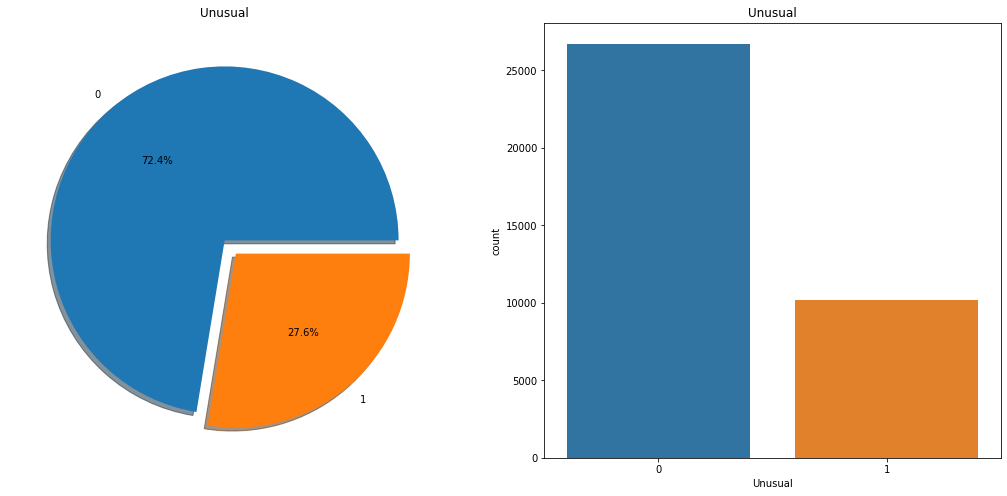

In [107]:
plt.figure(figsize=(15,10))
unusual = train['Unusual'].value_counts()
f,ax=plt.subplots(1,2,figsize=(18,8))
train['Unusual'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Unusual')
ax[0].set_ylabel('')
sns.countplot('Unusual',data=train_df,ax=ax[1])
ax[1].set_title('Unusual')
plt.show()

## Dimensionality reduction with PCA

Dimensionality reduction to see correlations between unusual data

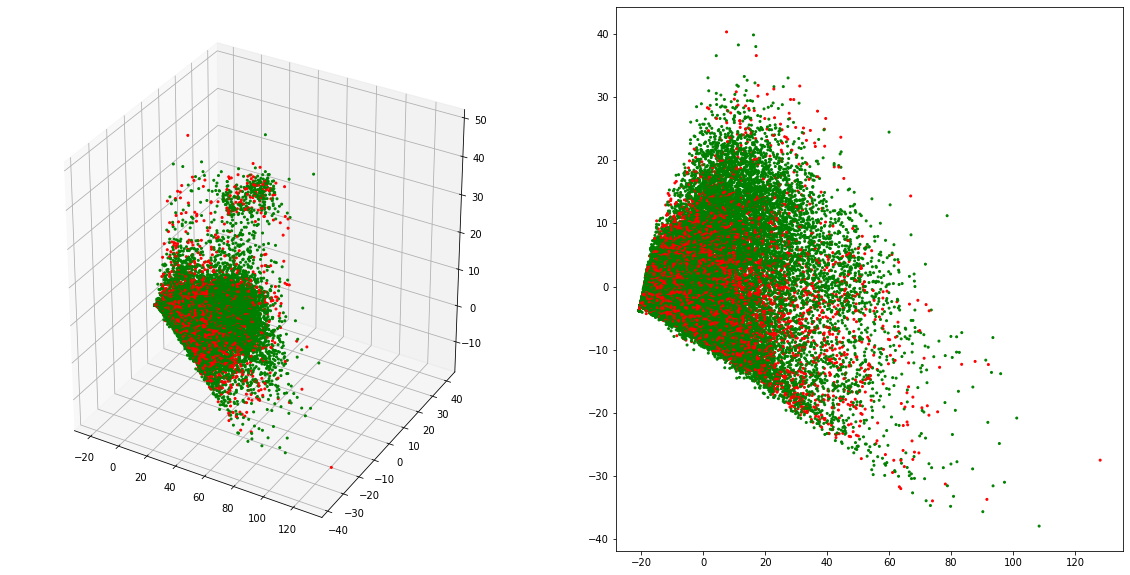

In [123]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)  # Reduce to 3 dimensions
X_reduce = pca.fit_transform(train)
pca2D = PCA(n_components=2)  # Reduce to 2 dimensions
X_reduce2 = pca2D.fit_transform(train)

fig = plt.figure(figsize=(20,10))
colors=['red' if x else 'green' for x in train.Unusual]

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:, 1], X_reduce[:, 2], s=4, alpha=1,color=colors)
ax1 = fig.add_subplot(122)
ax1.scatter(X_reduce2[:,0], X_reduce2[:, 1], s=4, alpha=1,color=colors)
plt.show()


# **Model Training**

**Split features and target**

In [15]:
X = train.drop('Unusual', axis=1)
y = train.Unusual

**Split data into training and validation**

In [16]:
# Split data into training and validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1, stratify=y)
X_test = test.copy()

Turn the values into an array for feeding the classification algorithms.

In [17]:
# Train and validation
X_train_np = X_train.to_numpy()
X_validation_np = X_validation.to_numpy()
y_train_np = y_train.to_numpy()
y_validation_np = y_validation.to_numpy()

# Test for submission
X_test_np = X_test.to_numpy()

In [18]:
X_train_np.shape, X_validation_np.shape, y_train_np.shape, y_validation_np.shape

((29523, 13), (7381, 13), (29523,), (7381,))

## Show metrics

In [151]:
def printMetrics(y_train, pred_train, y_validation, pred_validation):
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_validation, pred_validation)
    f_score = f1_score(y_validation, pred_validation)
    print('train accuracy: ', train_acc)
    print('train error:    ', 1. - train_acc)
    print('test accuracy:  ', test_acc)
    print('test error:     ', 1. - test_acc)
    print('-'*100)
    print('F-Score:\t', f_score)
    print('-'*100)

    print("\nTRAIN\n" + classification_report(y_train, pred_train))
    print('-'*100)
    print("\nTESTING\n" + classification_report(y_validation, pred_validation))


# **Classifier solutions**

## **RandomForest Classification**

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [23]:
"""rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}"""
rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 80],
    # 'max_features': [2, 3],
    # 'min_samples_leaf': [3, 4, 5],
    # 'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 500]
}

In [24]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_model = GridSearchCV(estimator = rf, param_grid = rf_param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

rf_model.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [50, 80],
                         'n_estimators': [200, 500]},
             verbose=2)

In [132]:
rf_model.best_params_, rf_model.best_score_, rf_model.best_estimator_

({'bootstrap': True, 'max_depth': 80, 'n_estimators': 500},
 0.9361176032246045,
 RandomForestClassifier(max_depth=80, n_estimators=500))

In [26]:
pred_train_rf = rf_model.predict(X_train)
pred_validation_rf = rf_model.predict(X_validation)

In [152]:
printMetrics(y_train, pred_train_rf, y_validation, pred_validation_rf)

train accuracy:  1.0
train error:     0.0
test accuracy:   0.9451293862620241
test error:      0.05487061373797586
----------------------------------------------------------------------------------------------------
F-Score:	 0.8927152317880794
----------------------------------------------------------------------------------------------------

TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21377
           1       1.00      1.00      1.00      8146

    accuracy                           1.00     29523
   macro avg       1.00      1.00      1.00     29523
weighted avg       1.00      1.00      1.00     29523

----------------------------------------------------------------------------------------------------

TESTING
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5344
           1       0.97      0.83      0.89      2037

    accuracy                           0.95   

## **XGBoost Classifier**

In [128]:
pipeline_xgb = Pipeline(steps=[('scaler', StandardScaler()), 
                               ('xgb_cl', XGBClassifier(objective="binary:logistic"))])

In [126]:
xgb_parameters = {
    "xgb_cl__max_depth": [5], 
    "xgb_cl__min_child_weight": [1],
    "xgb_cl__learning_rate": [0.15],
    "xgb_cl__gamma": [1],
    "xgb_cl__reg_alpha": [0], 
    "xgb_cl__scale_pos_weight": [1],
    "xgb_cl__subsample": [0.8],
    "xgb_cl__n_estimators": [550],
    "xgb_cl__colsample_bytree": [0.8],
}

In [129]:
xgb_model = GridSearchCV(estimator=pipeline_xgb, 
                        param_grid=xgb_parameters, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        cv=5,
                        verbose=100)

xgb_model.fit(X_train_np, y_train_np)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb_cl', XGBClassifier())]),
             n_jobs=4,
             param_grid={'xgb_cl__colsample_bytree': [0.8],
                         'xgb_cl__gamma': [1], 'xgb_cl__learning_rate': [0.15],
                         'xgb_cl__max_depth': [5],
                         'xgb_cl__min_child_weight': [1],
                         'xgb_cl__n_estimators': [550],
                         'xgb_cl__reg_alpha': [0],
                         'xgb_cl__scale_pos_weight': [1],
                         'xgb_cl__subsample': [0.8]},
             scoring='roc_auc', verbose=100)

In [130]:
xgb_model.best_params_, xgb_model.best_score_, xgb_model.best_estimator_

({'xgb_cl__colsample_bytree': 0.8,
  'xgb_cl__gamma': 1,
  'xgb_cl__learning_rate': 0.15,
  'xgb_cl__max_depth': 5,
  'xgb_cl__min_child_weight': 1,
  'xgb_cl__n_estimators': 550,
  'xgb_cl__reg_alpha': 0,
  'xgb_cl__scale_pos_weight': 1,
  'xgb_cl__subsample': 0.8},
 0.9990545737406744,
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('xgb_cl',
                  XGBClassifier(colsample_bytree=0.8, gamma=1,
                                learning_rate=0.15, max_depth=5,
                                n_estimators=550, subsample=0.8))]))

In [37]:
pred_train = xgb_model.predict(X_train_np)
pred_validation = xgb_model.predict(X_validation_np)

In [153]:
printMetrics(y_train_np, pred_train, y_validation_np, pred_validation)

train accuracy:  0.9996612810351252
train error:     0.0003387189648748068
test accuracy:   0.9895678092399404
test error:      0.010432190760059634
----------------------------------------------------------------------------------------------------
F-Score:	 0.9807932152656523
----------------------------------------------------------------------------------------------------

TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21377
           1       1.00      1.00      1.00      8146

    accuracy                           1.00     29523
   macro avg       1.00      1.00      1.00     29523
weighted avg       1.00      1.00      1.00     29523

----------------------------------------------------------------------------------------------------

TESTING
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5344
           1       1.00      0.97      0.98      2037

    accuracy

## **XGBoost with SMOTE (OverSampling) technique (Best)**

In [78]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=1.0 , random_state=1)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

Xsm_train = Xsm_train.to_numpy()
ysm_train = ysm_train.to_numpy()

In [79]:
sm_pipeline_xgb = Pipeline(steps=[('scaler', StandardScaler()), 
                               ('sm_xgb_cl', XGBClassifier(objective="binary:logistic"))])

In [90]:
xgb_parameters = {
    "sm_xgb_cl__max_depth": [5,15,20], 
    "sm_xgb_cl__min_child_weight": [1],
    "sm_xgb_cl__learning_rate": [0.15],
    "sm_xgb_cl__gamma": [1],
    "sm_xgb_cl__reg_alpha": [0], 
    "sm_xgb_cl__scale_pos_weight": [1],
    "sm_xgb_cl__subsample": [0.8],
    "sm_xgb_cl__n_estimators": [600],
    "sm_xgb_cl__colsample_bytree": [0.8, 0.08],
}

In [91]:
sm_xgb_model = GridSearchCV(estimator=sm_pipeline_xgb, 
                        param_grid=xgb_parameters, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        cv=5,
                        verbose=2)

sm_xgb_model.fit(Xsm_train, ysm_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sm_xgb_cl', XGBClassifier())]),
             n_jobs=4,
             param_grid={'sm_xgb_cl__colsample_bytree': [0.8, 0.08],
                         'sm_xgb_cl__gamma': [1],
                         'sm_xgb_cl__learning_rate': [0.15],
                         'sm_xgb_cl__max_depth': [5, 15, 20],
                         'sm_xgb_cl__min_child_weight': [1],
                         'sm_xgb_cl__n_estimators': [600],
                         'sm_xgb_cl__reg_alpha': [0],
                         'sm_xgb_cl__scale_pos_weight': [1],
                         'sm_xgb_cl__subsample': [0.8]},
             scoring='roc_auc', verbose=2)

In [92]:
sm_xgb_model.best_params_, sm_xgb_model.best_estimator_, sm_xgb_model.best_score_

({'sm_xgb_cl__colsample_bytree': 0.08,
  'sm_xgb_cl__gamma': 1,
  'sm_xgb_cl__learning_rate': 0.15,
  'sm_xgb_cl__max_depth': 20,
  'sm_xgb_cl__min_child_weight': 1,
  'sm_xgb_cl__n_estimators': 600,
  'sm_xgb_cl__reg_alpha': 0,
  'sm_xgb_cl__scale_pos_weight': 1,
  'sm_xgb_cl__subsample': 0.8},
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('sm_xgb_cl',
                  XGBClassifier(colsample_bytree=0.08, gamma=1,
                                learning_rate=0.15, max_depth=20,
                                n_estimators=600, subsample=0.8))]),
 0.9999373955933896)

In [93]:
sm_pred_train = sm_xgb_model.predict(Xsm_train)
sm_pred_validation = sm_xgb_model.predict(X_validation_np)

In [154]:
printMetrics(ysm_train, sm_pred_train, y_validation, sm_pred_validation)

train accuracy:  0.9998596622538242
train error:     0.00014033774617583372
test accuracy:   0.9953935781059478
test error:      0.004606421894052248
----------------------------------------------------------------------------------------------------
F-Score:	 0.9915966386554623
----------------------------------------------------------------------------------------------------

TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21377
           1       1.00      1.00      1.00     21377

    accuracy                           1.00     42754
   macro avg       1.00      1.00      1.00     42754
weighted avg       1.00      1.00      1.00     42754

----------------------------------------------------------------------------------------------------

TESTING
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5344
           1       1.00      0.98      0.99      2037

    accurac

# **Metrics and results**

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

rf_pred = cross_val_predict(rf_model, X_train, y_train, cv=5)

In [ ]:
xgb_pred = cross_val_predict(xgb_model, X_train_np, y_train_np, cv=4)

In [95]:
sm_xgb_pred = cross_val_predict(sm_xgb_model.best_estimator_, Xsm_train, ysm_train, cv=4)

In [96]:
print("RandomForest: {}".format(roc_auc_score(y_train, rf_pred)) )
print("XGBoost: {}".format(roc_auc_score(y_train_np, xgb_pred)) )
print("XGBoost with SMOTE: {}".format(roc_auc_score(ysm_train, sm_pred_train)) )

RandomForest: 0.9005157616034387
XGBoost: 0.9774062717799007
XGBoost with SMOTE: 0.9998596622538243


## **F1-Score (Metric for competition)**

In [168]:
data = {'Technique': ['RandomForest', 'XGBoost CL', 'XGBoost overSampled'],
        'F1-Score': [round(f1_score(y_validation, pred_validation_rf),3), 
                    round(f1_score(y_validation_np, pred_validation),3),
                    round(f1_score(y_validation, sm_pred_validation),3)]
        }

fscores = pd.DataFrame(data)
fscores

,Technique,F1-Score
0,RandomForest,0.893
1,XGBoost CL,0.981
2,XGBoost overSampled,0.992


## **Confusion matrix**

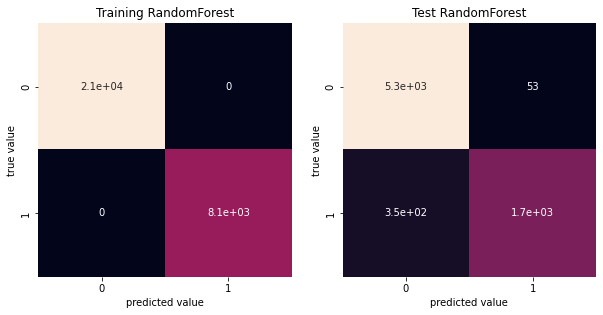

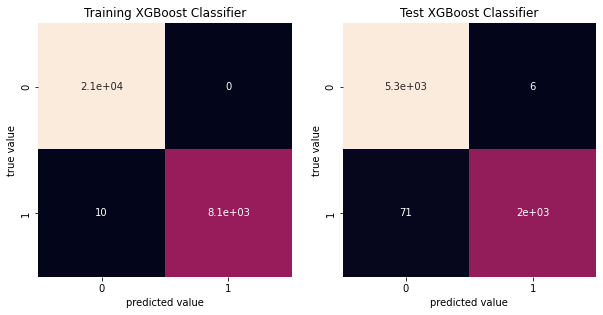

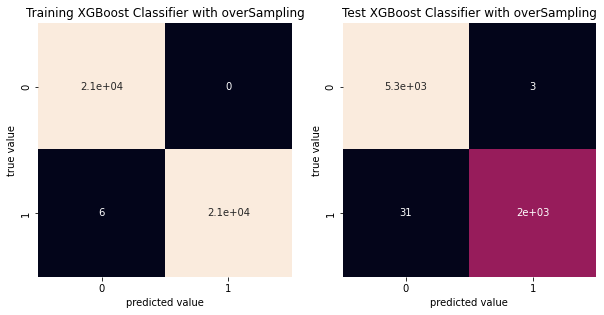

In [150]:
def plot_confusion_matrix(y_train, pred_train, y_validation, pred_validation, model):
    train_cmat = confusion_matrix(y_train, pred_train)
    test_cmat = confusion_matrix(y_validation, pred_validation)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    sns.heatmap(train_cmat, square=True, annot=True, cbar=False)
    plt.title(f'Training {model}')
    plt.xlabel('predicted value')
    plt.ylabel('true value');

    plt.subplot(122)
    sns.heatmap(test_cmat, square=True, annot=True, cbar=False)
    plt.title(f'Test {model}')
    plt.xlabel('predicted value')
    plt.ylabel('true value');

    plt.show()

plot_confusion_matrix(y_train, pred_train_rf, y_validation, pred_validation_rf, 'RandomForest')
plot_confusion_matrix(y_train_np, pred_train, y_validation_np, pred_validation, 'XGBoost Classifier')
plot_confusion_matrix(ysm_train, sm_pred_train, y_validation, sm_pred_validation, 'XGBoost Classifier with overSampling')

## **ROC curve**

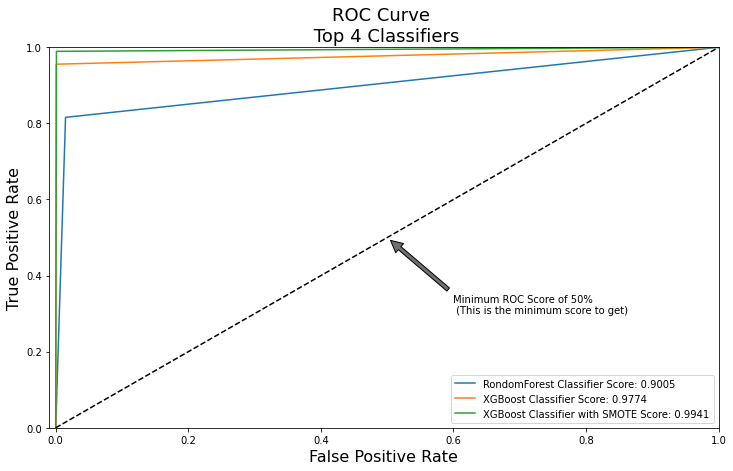

In [105]:
rf_fpr, rf_tpr, rf_thresold = roc_curve(y_train, rf_pred)
xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(y_train_np, xgb_pred)
sm_xgb_fpr, sm_xgb_tpr, sm_xgb_thresold = roc_curve(ysm_train, sm_xgb_pred)
# knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)


def graph_roc_curve_multiple(rf_fpr, rf_tpr, 
                             xgb_fpr, xgb_tpr,
                             sm_xgb_fpr, sm_xgb_tpr):
    plt.figure(figsize=(12,7))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(rf_fpr, rf_tpr, label='RondomForest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train_np, xgb_pred)))
    plt.plot(sm_xgb_fpr, sm_xgb_tpr, label='XGBoost Classifier with SMOTE Score: {:.4f}'.format(roc_auc_score(ysm_train, sm_xgb_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(rf_fpr, rf_tpr, xgb_fpr, xgb_tpr, sm_xgb_fpr, sm_xgb_tpr)
plt.show()

## **Feature Importance**

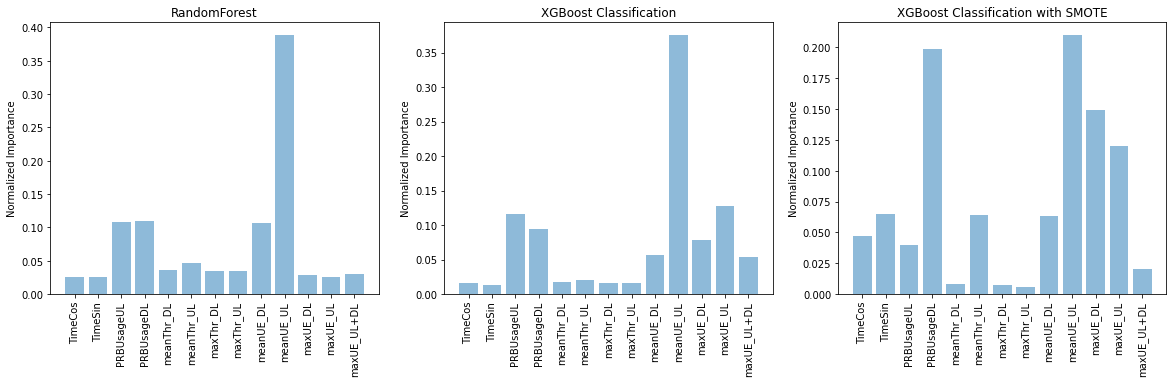

In [144]:
models = [(rf_model.best_estimator_, 'RandomForest'),
          (xgb_model.best_estimator_.named_steps["xgb_cl"], 'XGBoost Classification'),
          (sm_xgb_model.best_estimator_.named_steps["sm_xgb_cl"], 'XGBoost Classification with SMOTE')]

fig = plt.figure(figsize=(20,5)) 
for idx, model in enumerate(models):
    feature_imp = model[0].feature_importances_
    columns = X_train.columns
    plt.subplot(1,3,idx+1)
    plt.bar(np.arange(13) , feature_imp, align='center', alpha=0.5)
    plt.xticks(np.arange(13), columns, rotation='vertical')
    plt.ylabel('Normalized Importance')
    plt.title(model[1])
plt.show()

# **Model Submission**

In [99]:
sm_xgb_preds = sm_xgb_model.predict(X_test_np)

In [100]:
neg, pos = np.bincount(sm_xgb_preds)
total = neg + pos
print('Examples:\n    Total: {}\n    Unusual: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 9158
    Unusual: 2399 (26.20% of total)



In [103]:
out = pd.DataFrame(np.arange(1,9159), columns=['Id'])
out['Label'] = sm_xgb_preds

out.to_csv('predictions01.csv', index=False)

submission = pd.read_csv('predictions01.csv')
submission

,Id,Label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
9153,9154,0
9154,9155,1
9155,9156,0
9156,9157,0


In [104]:
neg, pos = np.bincount(submission.Label)
total = neg + pos
print('Examples:\n    Total: {}\n    Unusual: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 9158
    Unusual: 2399 (26.20% of total)

